In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.sparse import diags, eye, kron
from scipy.sparse.linalg import spsolve

---
# 1. Finite differences approximation

---
# 3. 2D Elliptic PDEs

**Exercise 1.** Consider the **9-point Laplacian approximation**.

* (a) Obtain its **local truncation error** by using Taylor expansions.

In [ ]:
# made on paper

* (b) Modify your 2D Poisson solver to use the 9-point finite difference Laplacian instead of the standard 5-point stencil

In [26]:
def poisson(m):
    """
    Solve the 2D Poisson equation:
        ∇²u = -2 sin(x) sin(y),   (x,y) ∈ [0,2π] × [0,2π],
        u = 0 on the boundary.

    Parameters
    ----------
    m : int
        Number of interior grid points in each direction.

    Returns
    -------
    X, Y : 2D ndarrays
        Meshgrid of all grid points including boundaries.
    U : 2D ndarray
        Numerical solution at all grid points.
    """
    # Step 1: Discretize domain [0, 2π] × [0, 2π]
    h = (2*np.pi)/(m+1) 

    # Step 2: Build sparse matrix A for the 9-point Laplacian
    B = diags([0*np.ones(m-2), 4*np.ones(m-1), -20*np.ones(m), 4*np.ones(m-1), 0*np.ones(m-2)],
        offsets=[-2, -1, 0, 1, 2], format='csr')

    C = diags([1*np.ones(m-1), 4*np.zeros(m), 1*np.ones(m-1)],
        offsets=[-1, 0, 1], format='csr')

    S = diags([1*np.ones(m-1)],
        offsets=[1], format='csr')

    I = eye(m, format='csr')

    ## reconstruct A using Kronecker products
    A = 1/(6*h**2) * (kron(I,B) + kron(S, C) + kron(S.T, C.T))

    # Step 3: Assemble RHS vector with f(x,y) = -2 sin(x) sin(y)
    x = np.linspace(0, 2*np.pi, m+2)
    y = np.linspace(0, 2*np.pi, m+2)
    X, Y = np.meshgrid(x, y)

    F = -2*np.sin(X[1:-1, 1:-1])*np.sin(Y[1:-1, 1:-1])  # only interior points
    F += h**2/3 *  np.sin(X[1:-1, 1:-1])*np.sin(Y[1:-1, 1:-1])  
    F = F.reshape(m**2)  # flatten to 1D array

    # Step 4: Solve linear system AU = F
    U = spsolve(A, F)
    U = U.reshape((m, m))  # reshape back to 2D array

    # Step 5: Reconstruct solution including boundary values
    U_full = np.zeros((m+2, m+2))
    U_full[1:-1, 1:-1] = U  # interior points
    U = U_full

    return X, Y, U

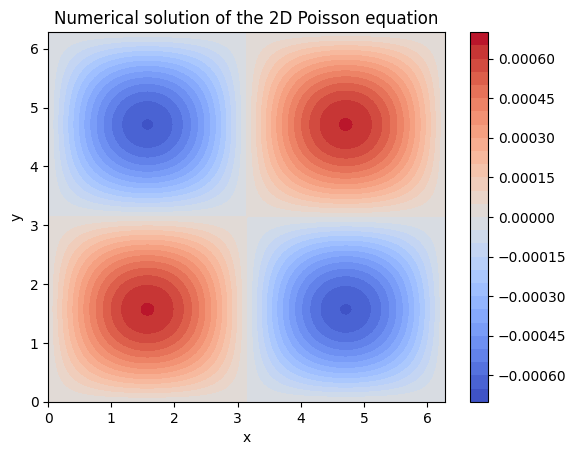

In [27]:
X, Y, U = poisson(300)
plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title('Numerical solution of the 2D Poisson equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

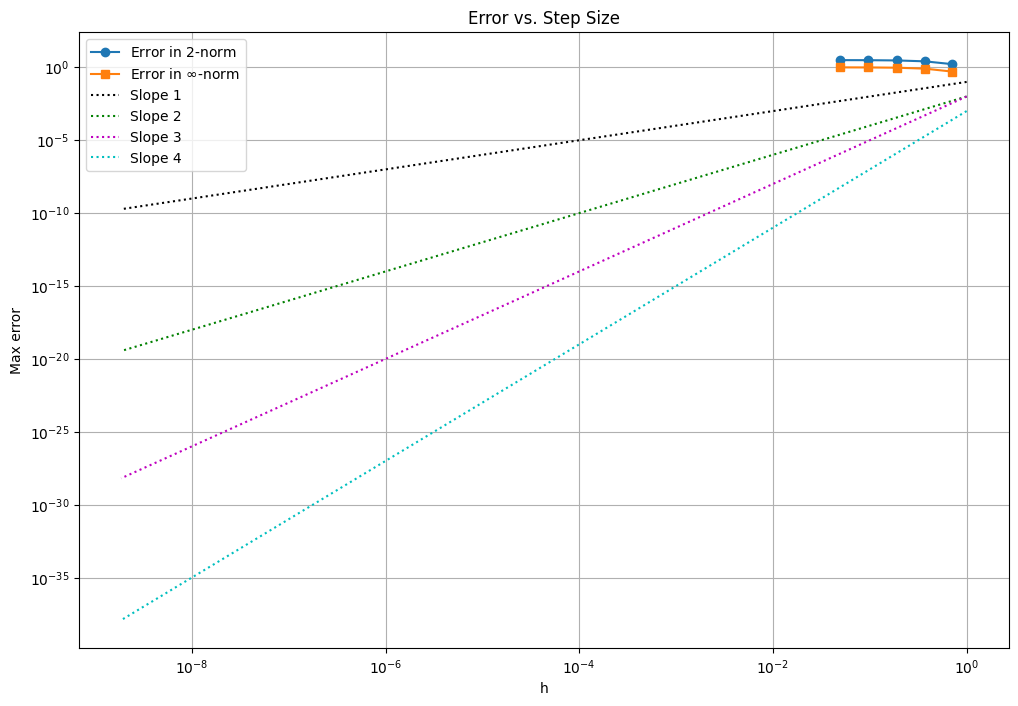

In [28]:
m_list = [8, 16, 32, 64, 128]

errors2 = []
errorsinf = []
hs = []

for m in m_list:
    X, Y, U_it = poisson(m)
    h = (2*np.pi)/(m+1)
    E = U_it - np.sin(X)*np.sin(Y)
    
    errorinf = np.max(np.abs(E))          
    error2 = np.linalg.norm(E.ravel(), 2) * h

    errors2.append(error2)
    errorsinf.append(errorinf)
    hs.append(h)

hvec = 1.0 / 2**np.arange(30)

plt.figure(figsize=(12, 8))
plt.loglog(hs, errors2, marker='o', label=r"Error in $2$-norm")
plt.loglog(hs, errorsinf, marker='s', label=r"Error in $\infty$-norm")
plt.loglog(hvec, 0.1*hvec**1, 'k:', label="Slope 1")
plt.loglog(hvec, 0.01*hvec**2, 'g:', label="Slope 2")
plt.loglog(hvec, 0.01*hvec**3, 'm:', label="Slope 3")
plt.loglog(hvec, 0.001*hvec**4, 'c:', label="Slope 4")
#plt.xlim([min(hs), max(hs)])
#plt.ylim([min(errorsinf), max(errorsinf)])
plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Error vs. Step Size')
plt.legend()
plt.grid(True, which='both')

**Exercise 2.** Consider the **Laplace equation**

$$
\begin{aligned}
\Delta u + \lambda u &= 0, & 0 < x, y < 1, \
u &= 0, & \text{on the boundaries}.
\end{aligned}
$$

* (a) Show that the **eigenvalues and eigenvectors** for this problem are

$$
\lambda_{k, l} = \pi^2 (l^2 + k^2), \quad l, k = 1, 2, \dots,
$$
$$
u_{k, l}(x, y) = \sin(k \pi x) \sin(l \pi y).
$$

* (b) Show that the standard central finite difference scheme using the five-point stencil is stable for the **Poisson equation**.

  *Hint: The eigenvectors for $\mathbf{A}^h \mathbf{U}^h = \mathbf{F}$ (eigen-grid functions) are*

  $$
  v_{p, q}^{ij} = \sin(p \pi h) \sin(q \pi h),
  \quad i, j, p, q = 1, 2, \dots, m.
  $$

  *Moreover, remember that*
  $$
  | (\mathbf{A}^h)^{-1} |_2 = \frac{1}{\min |\lambda_i (\mathbf{A}^h)|}.
  $$



**Exercise 3.** Write down the **coefficient matrix** of the finite difference method using the standard central five-point stencil for the Poisson equation defined on the rectangle $[a, b] \times [c, d]$. Take $m=n=3$ and assume a **Dirichlet boundary condition** at $x=a$, $y=c$ and $y=d$, and a **Neumann boundary condition** $\partial u / \partial n = g(y)$ at $x=b$. Use the **ghost point method** to deal with the Neumann boundary condition.

**Exercise 4.** Write a solver for the **Laplace equation**

$$
\begin{aligned}
\frac{1}{r} \frac{\partial}{\partial r} \left(r \frac{\partial u}{\partial r}\right) + \frac{1}{r^2} \frac{\partial^2 u}{\partial \theta^2} &= 0, & 0 < r < 1,\, 0 < \theta < 2\pi, \,
  u(r, \theta) &= u(r, \theta + 2\pi), & 0 \le r \le 1, \,
  |u(r, \theta)| &< \infty, & \forall (r, \theta) \in \Omega, \,
  u(1, \theta) &= g(\theta), & 0 \le \theta < 2\pi.
  \end{aligned}
  $$

As a check, consider a numerical test to analyze the **convergence**, i.e. choose $g(\theta)$ as you wish and do a **grid refinement study**.

Remember that the general solution to this problem is

$$
u(r, \theta) = \sum_{n=0}^\infty A_n \cos(n \theta) r^n + \sum_{n=1}^\infty B_n \sin(n \theta) r^n.
$$

---
Tests

In [35]:
from aux_funcs import poisson_general

X, Y, U = poisson_general(300, 300)
plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title('Numerical solution of the 2D Poisson equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

NameError: name 'm' is not defined